# Question & Motivation

We wanted to determine what indicators of gentrification are in the United States. To begin, we define gentrification as the process of renovating deteriorated urban neighborhoods, usually by the influx of more affluent residents and often at the cost of displacing minorities.

Our motivation for this project was that by identifying gentrified areas and common traits between gentrified areas, we would be able to:
- 1) better understand the associated effects / potential causes of gentrification
- 2) identify the process of gentrification earlier on

Given earlier identification, the hope is that local and state governments could use this tool to help protect groups of existing residents that are being forced out by rising rents and higher cost of living.

# Data Acquisition + Cleaning

## Data Sources & Methodology
For our research proposal, we wanted to be label geographic areas as gentrified or not gentrified, and then find variables correlated with gentrification that would help us predict it. 

The first step then was to establish how we classify an area's gentrification status. We did so by following Governing.com's  [methodology](https://www.governing.com/gov-data/gentrification-report-methodology.html). And the research it was based off of by [Freeman](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjz9NCL5-7hAhXSv54KHYX3B9MQFjAAegQIBhAB&url=https%3A%2F%2Fwww.researchgate.net%2Fpublication%2F249734755_Displacement_or_Succession_Residential_Mobility_in_Gentrifying_Neighborhoods&usg=AOvVaw3yboBkbsz7X7z8es2PZgwU). 

 - 1st Test - Eligibility for Gentrification
  - Population of at least 500 residents
- Median household income in bottom 40th percentile for metro area (county)
- Median home value in bottom 40th percentile for metro area

- 2nd Test - Did gentrification happen?
 - Increase in educational attainment for Bachelor's degrees (age 25+), in the top 50th percentile
 - Median home value increased

The data we needed for applying this methodology are detailed above, and then for the second part of our analysis we needed access to other various indicator variables we wanted to test (e.g. home rental status, transportation data, etc.)

Based off of these needs, we choose to go with the publicly available **[American Community Survey (ACS)](https://www.census.gov/data/developers/data-sets/acs-1year.html)**. The ACS is an ongoing survey that covers a sample of nearly 3.5 million addresses in the US. The data is released at 1 year intervals. ACS includes demographic information, economic factors (e.g. income and earnings, commuting to work), and housing data. This was perfect for what we wanted to accomplish.

## Ethical Collection Standards
We wanted to make sure that the data was collected in a way that didn't bias it or otherwise violate ethical standards like we discussed in class. The ACS has both privacy policies and data suppression plans in place. Their privacy policy insures integrity in collecting data that doesn't have the government infringing on personal liberties and the suppression policy keeps the statistics at a large enough geographical reporting area to keep anyone from putting information together to find out an individual or their personal information. More on the [privacy policy](https://www.census.gov/privacy/) and [data suppression](https://www.census.gov/programs-surveys/acs/technical-documentation/data-suppression.html).

## Challenges with using ACS
We used the ACS API and requests framework to pull our data. Here are a few of the challenges we came across:
- **Geographic Specificity**: In order to do the percentile analysis for the Governing methodology (e.g. bottom 40% in median income), we needed to find consistent geographical units, and subunits. This required quite a bit of exploring in terms of what each unit meant. Here's a list of [geographies](https://api.census.gov/data/2017/acs/acs5/examples.html). 
- **Primary Table Key**: We ended up using census tracts and counties as our geographical units. One thing to note is that the tract variable on its own isn't a unique identifier - the tract numbers are in fact re-used from state to state. Thus, the "NAME" variable of a place had to be used as the table's primary key. 
- **Percentile Calculations**: When evaluating the percentile value for a tract, we looked at counties as the larger geographic unit. These counties however, had to be turned into State_County tuples because County numbers were re-used per state.
- **Variable names**: The list of [variables](https://api.census.gov/data/2017/acs/acs5/variables.html) was difficult to look through to search for attributes, and not clear in its definitions. We had to find a separate [page](http://proximityone.com/apigateway_acs5year.htm) that contained better descriptors.
- **State IDs** used in API aren't sequential ordered (some had IDs in the 70's range).

## **NOTE**: LOADING CSVs
There are multiple sections that provide the option to load CSVs for data (and thus save enormous amounst of time b/c they skip querying the API). These should be provided in a zip file.

## Acquiring and Cleaning the Base Data

### Imports

In [43]:
import requests
import ast
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_selection import RFE
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 22})

### Helper Functions

In [2]:
def responseToDataFrame(responseText):
    responseText = responseText[1:-1].split(",\n")
    cleanList = []
    responseText = [json.loads(i) for i in responseText] # <- cleaner but doesn't allow for error handling
    dataframe = pd.DataFrame(responseText[1:], columns = responseText[0])
    return dataframe

def queryAPI(year, columnCodes, csvName):
    # INPUT: Int, list of Strings, String - end with .csv
    data = pd.DataFrame(columns = columnCodes+['NAME', 'state', 'county', 'tract'])
    inputString = "https://api.census.gov/data/"+str(year)+"/acs/acs5?get="
    for column in columnCodes:
        inputString += column+","
    inputString += "NAME&for=tract:*&in=state:"
    for stateID in states:
        r = requests.get(inputString+stateID)
        data = data.append(responseToDataFrame(r.text))
    data.to_csv(csvName, encoding='utf-8', index=False)
    return data

def changeToNumeric(data, column):
    return pd.to_numeric(data[column])

def perf_measure(y_actual, y_hat):
    TPos = 0
    FPos = 0
    TNeg = 0
    FNeg = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TPos += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FPos += 1
        if y_actual[i]==y_hat[i]==0:
            TNeg += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FNeg += 1
    return(TPos, FPos, TNeg, FNeg)

In [37]:
# Get all the stateIDs we'll be using (not 0-50 for some reason)
s = requests.get("https://api.census.gov/data/2012/acs/acs5?get=B00001_001E,NAME&for=county:*")
states = set(responseToDataFrame(s.text)['state'])

### Pulling from the ACS API

Let's figure out what the variable names are for the attributes we want for determining gentrification:
- B01001_001E <- Estimate!!Total (population)
- B19013_001E <- Estimate!!Median household income in the past 12 months (in 2017 inflation-adjusted dollars)
- B25077_001E <- Median house price
- B15003_022E <- Estimate!!Total!!Bachelor's degree

#### Load CSV option available

In [ ]:
# SKIP if you have the CSV 
data_2012 = queryAPI(2012, ['B01001_001E', 'B19013_001E', 'B15003_022E', 'B25077_001E'], "2012Base.csv")
data_2017 = queryAPI(2017, ['B01001_001E', 'B19013_001E', 'B15003_022E', 'B25077_001E'], "2017Base.csv")

In [ ]:
# USE this if you already have the CSVs - Saves time from waiting for API
data_2012 = pd.read_csv('2012Base.csv')
data_2017 = pd.read_csv('2017Base.csv')

### Data Cleaning

In [5]:
# Change columns to be the proper types and names
baseCols = ['B01001_001E', 'B19013_001E', 'B15003_022E', 'B25077_001E']
for col in baseCols:
    data_2012[col] = changeToNumeric(data_2012, col)
    data_2017[col] = changeToNumeric(data_2017, col)
    
# Change column names to be more intuitive
data_2012 = data_2012.rename(index = str, columns={"B01001_001E": "population_2012", "B19013_001E": "income_2012", "B15003_022E": "bachelors_2012", "B25077_001E": "home_2012"})
data_2017 = data_2017.rename(index = str, columns={"B01001_001E": "population_2017", "B19013_001E": "income_2017", "B15003_022E": "bachelors_2017", "B25077_001E": "home_2017"})

# Removing rows that have negative values as these are placeholders when info is missing and will skew data
for cols in data_2012.columns.tolist()[1:4]:
    data_2012 = data_2012.loc[data_2012[cols] > 0]
for cols in data_2017.columns.tolist()[1:4]:
    data_2017 = data_2017.loc[data_2017[cols] > 0]

### Data Merging

#### Load CSV Option Available

In [ ]:
# SKIP if you have the CSV
full_table = data_2012.merge(data_2017, on=('NAME'))
full_table = full_table[['NAME', 'state_x', 'county_x', 'tract_x', 'population_2012', 'population_2017', 'income_2012', 'income_2017', 'bachelors_2012', 'bachelors_2017', 'home_2012', 'home_2017']]
full_table = full_table.rename(index = str, columns={"state_x": "state", "county_x": "county", "tract_x": "tract"})
full_table['State_County'] = full_table.apply(lambda x: str(x['state']) + " - " + str(x['county']), axis=1)
full_table.to_csv("Full_table_base.csv", encoding='utf-8', index=False)

In [ ]:
# USE if you have the CSV
full_table = pd.read_csv('Full_table_base.csv')

### Feature Extraction

In [7]:
full_table['EDU Change'] = (full_table['bachelors_2017'] / full_table['population_2017']) - (full_table['bachelors_2012'] / full_table['population_2012'])
full_table['MedHomeVal Inc'] = full_table['home_2017'] > full_table['home_2012']
full_table['MedHomeVal Change'] = full_table['home_2017'] - full_table['home_2012']

## Identifying Gentrified Tracts

### 1) Check if area is eligible for gentrification

In [8]:
# First check for Gentrification eligibility
firstLookUp = full_table.groupby("State_County").quantile(.4) # Calculate quantiles to filter by
print("STARTING TABLE TRACTS: ",  full_table.shape[0])

first_check = full_table[full_table['population_2012']>500]
print("ELIGIBLE AREAS AFTER POPULATION FILTER: ",first_check.shape[0])

incomeFilter = first_check.apply(lambda x: x['income_2012'] <= firstLookUp['income_2012'][x['State_County']], axis=1)
first_check = first_check[incomeFilter]
print("ELIGIBLE AREAS AFTER INCOME FILTER: ",first_check.shape[0])

homeFilter = first_check.apply(lambda x: x['home_2012'] <= firstLookUp['home_2012'][x['State_County']], axis=1)
first_check = first_check[homeFilter]
print("ELIGIBLE AREAS AFTER HOME FILTER: ", first_check.shape[0])

STARTING TABLE TRACTS:  71533
ELIGIBLE AREAS AFTER POPULATION FILTER:  71460
ELIGIBLE AREAS AFTER INCOME FILTER:  29252
ELIGIBLE AREAS AFTER HOME FILTER:  21097


### 2) Check if area gentrified over time

In [9]:
secondLookUp = full_table.groupby('State_County').quantile(0.50)
second_check = first_check

educationFilter = second_check.apply(lambda x: x['EDU Change'] >= secondLookUp['EDU Change'][x['State_County']], axis=1)
second_check = second_check[educationFilter]
print("ELIGIBLE AREAS AFTER EDUCATION FILTER: ", second_check.shape[0])

second_check = second_check[second_check["MedHomeVal Inc"] == True]
print("ELIGIBLE AREAS AFTER INCREASE HOME VAL FILTER: ", second_check.shape[0])

ELIGIBLE AREAS AFTER EDUCATION FILTER:  10500
ELIGIBLE AREAS AFTER INCREASE HOME VAL FILTER:  6303


### 3) Compile Final Table

In [26]:
gentrified = set(second_check['NAME'])
def checkBool(gentrified, name):
    if (name in gentrified):
        return 1
    else:
        return 0

eligible = first_check
eligible['GENTRIFIED'] = eligible.apply(lambda x: checkBool(gentrified, x['NAME']), axis=1)
eligible.head()

,NAME,state,county,tract,population_2012,population_2017,income_2012,income_2017,bachelors_2012,bachelors_2017,home_2012,home_2017,State_County,EDU Change,MedHomeVal Inc,MedHomeVal Change,GENTRIFIED
2,"Census Tract 8808, Cape Girardeau County, Miss...",29,31,880800,4124,4131,36550,27813,160,195,86600,105000,29 - 31,0.008407,True,18400,1
3,"Census Tract 8809, Cape Girardeau County, Miss...",29,31,880900,2291,2717,33983,28235,227,227,83900,74600,29 - 31,-0.015535,False,-9300,0
8,"Census Tract 8814, Cape Girardeau County, Miss...",29,31,881400,3028,2211,14242,16022,76,36,47300,33900,29 - 31,-0.008817,False,-13400,0
10,"Census Tract 8816, Cape Girardeau County, Miss...",29,31,881600,3001,3245,32650,26593,199,177,85400,79500,29 - 31,-0.011766,False,-5900,0
13,"Census Tract 9603, Carroll County, Missouri",29,33,960300,4028,4053,32424,32466,310,303,69000,73200,29 - 33,-0.002202,True,4200,1


# Modeling the Data

## Feature Selection

Now that we have our labeled table, we wanted to think of what other variables could be potentially useful in helping predict gentrification.

Because gentrification is a process, we were interested in time series data, not necessarily static points (e.g. population for 2017). This is because we weren’t evaluating if a tract is gentrified at a given point in time, but instead if an area became gentrified over a time period. This means we wanted to look at features such as average rate of change of X variable, or an absolute change over Y time.

Here are some variables we determined could be interesting:
- **Change in percentage of houses that are renter occupied** (B25003_003E / B25003_001E) <- influx of people could have more renters
- **Change in percentage of houses that are vacant** (B25002_003E / B25002_001E)  <- influx of people could reduce proportion of vacant houses
- **Change in population demographic breakdown** <- gentrification involves displacing of minorities (Total: C02003_001E, White: C02003_003E, Black or African American: C02003_004E, Asian: C02003_006E)
- **Reduced (or increased) travel time to work** (B08013_001E) < Estimate!!Aggregate travel time to work (in minutes)
- **Change in number of vehicles used in commute** (B08015_001E) <- Estimate!!Aggregate number of vehicles (car, truck, or van) used in commuting

What might also be interesting to look at in the future is if we play around with some of our original variables, but look at rate of change (e.g. how fast was median income increasing within the first 2 years). This could potentially help us predict gentrification earlier e.g. if all areas that become gentrified start off with an X% rate of increase in median household income per year. Or maybe we look at acceleration - how quickly is the rate of increase changing?

### Pull new variables + extra years (for velocity & acceleration)

#### Load CSV Option Available

In [ ]:
# SKIP if you already have the CSVs
data_2012_2 = queryAPI(2012, ['B25003_003E', 'B25003_001E', 'B25002_003E', 'B25002_001E', 'C02003_001E', 'C02003_004E','C02003_006E','B08013_001E', 'B08015_001E'], '2012Extra.csv')
data_2017_2 = queryAPI(2017, ['B25003_003E', 'B25003_001E', 'B25002_003E', 'B25002_001E', 'C02003_001E', 'C02003_004E','C02003_006E','B08013_001E', 'B08015_001E'], '2017Extra.csv')
data_2012_3 = queryAPI(2012, ['B15003_023E', 'B15003_024E', "B25003A_001E",'B25003B_001E','B25003D_001E','B25004_001E','B25010_001E','B25018_001E'], '2012Extra2.csv')
data_2017_3 = queryAPI(2017, ['B15003_023E', 'B15003_024E', "B25003A_001E",'B25003B_001E','B25003D_001E','B25004_001E','B25010_001E','B25018_001E'], '2017Extra2.csv')

data_2013 = queryAPI(2013, ['B01001_001E', 'B19013_001E', 'B15003_022E', 'B25077_001E'], "2013Base.csv")
data_2014 = queryAPI(2014, ['B01001_001E', 'B19013_001E', 'B15003_022E', 'B25077_001E'], "2014Base.csv")
data_2015 = queryAPI(2015, ['B01001_001E', 'B19013_001E', 'B15003_022E', 'B25077_001E'], "2015Base.csv")

In [12]:
# USE if you have the CSVs
data_2012_2 = pd.read_csv("2012Extra.csv")
data_2017_2 = pd.read_csv("2017Extra.csv")
data_2013 = pd.read_csv("2013Base.csv")
data_2014 = pd.read_csv("2014Base.csv")
data_2015 = pd.read_csv("2015Base.csv")
data_2012_3 = pd.read_csv("2012Extra2.csv")
data_2017_3 = pd.read_csv("2017Extra2.csv")

### Cleaning the data

In [14]:
baseCols = ['B01001_001E', 'B19013_001E', 'B15003_022E', 'B25077_001E']
extraCols = ['B25003_003E', 'B25003_001E', 'B25002_003E', 'B25002_001E', 'C02003_001E', 'C02003_004E','C02003_006E','B08013_001E', 'B08015_001E']
extraCols2 = ['B15003_023E', 'B15003_024E',"B25003A_001E",'B25003B_001E','B25003D_001E','B25004_001E','B25010_001E','B25018_001E']

for col in extraCols:
    data_2012_2[col] = changeToNumeric(data_2012_2, col)
    data_2017_2[col] = changeToNumeric(data_2017_2, col)

for col in extraCols2:
    data_2012_3[col] = changeToNumeric(data_2012_3, col)
    data_2017_3[col] = changeToNumeric(data_2017_3, col)
    
for col in baseCols:
    data_2013[col] = changeToNumeric(data_2013, col)
    data_2014[col] = changeToNumeric(data_2014, col)
    data_2015[col] = changeToNumeric(data_2015, col)    

In [15]:
data_2013 = data_2013.rename(index = str, columns={"B01001_001E": "population_2013", "B19013_001E": "income_2013", "B15003_022E": "bachelors_2013", "B25077_001E": "home_2013"})
data_2014 = data_2014.rename(index = str, columns={"B01001_001E": "population_2014", "B19013_001E": "income_2014", "B15003_022E": "bachelors_2014", "B25077_001E": "home_2014"})
data_2015 = data_2015.rename(index = str, columns={"B01001_001E": "population_2015", "B19013_001E": "income_2015", "B15003_022E": "bachelors_2015", "B25077_001E": "home_2015"})

data_2012_2 = data_2012_2.rename(index = str, columns = {'B25003_003E': "HousesRented_2012", 'B25003_001E':"TotalHousesTenure_2012", 'B25002_003E': "HousesVacant_2012", 'B25002_001E': "TotalHousesOcc_2012", 'C02003_001E':"TotalPopDem_2012", 'C02003_004E':"AfAm_2012",'C02003_006E':"AsianDem_2012",'B08013_001E':"TravelTime_2012", 'B08015_001E':"VehiclesUsed_2012"})
data_2017_2 = data_2017_2.rename(index = str, columns = {'B25003_003E': "HousesRented_2017", 'B25003_001E':"TotalHousesTenure_2017", 'B25002_003E': "HousesVacant_2017", 'B25002_001E': "TotalHousesOcc_2017", 'C02003_001E':"TotalPopDem_2017", 'C02003_004E':"AfAm_2017",'C02003_006E':"AsianDem_2017",'B08013_001E':"TravelTime_2017", 'B08015_001E':"VehiclesUsed_2017"})
data_2012_3 = data_2012_3.rename(index = str, columns = {'B15003_023E': "Masters_Degrees_2012", 'B15003_024E':"Professional_Degrees_2012", "B25003A_001E" : "White_Houses_2012",'B25003B_001E': "African_American_2012",'B25003D_001E' : "Asian_2012",'B25004_001E' : "Vacant_Homes_2012",'B25010_001E' :"Avg_House_Size_2012",'B25018_001E' : "Median_Num_Rooms_2012"})
data_2017_3 = data_2017_3.rename(index = str, columns = {'B15003_023E': "Masters_Degrees_2017", 'B15003_024E':"Professional_Degrees_2017","B25003A_001E" : "White_Houses_2017",'B25003B_001E': "African_American_2017",'B25003D_001E' : "Asian_2017",'B25004_001E' : "Vacant_Homes_2017",'B25010_001E' :"Avg_House_Size_2017",'B25018_001E' : "Median_Num_Rooms_2017"})

data_2013 = data_2013.drop(columns=['state', 'county', 'tract'])
data_2014 = data_2014.drop(columns=['state', 'county', 'tract'])
data_2015 = data_2015.drop(columns=['state', 'county', 'tract'])
data_2012_2 = data_2012_2.drop(columns=['state', 'county', 'tract'])
data_2017_2 = data_2017_2.drop(columns=['state', 'county', 'tract'])
data_2012_3 = data_2012_3.drop(columns=['state', 'county', 'tract'])
data_2017_3 = data_2017_3.drop(columns=['state', 'county', 'tract'])

### Merging the data

In [16]:
master = eligible
master = master.merge(data_2017_2, on=('NAME'))
master = master.merge(data_2012_2, on=('NAME'))
master = master.merge(data_2017_3, on=('NAME'))
master = master.merge(data_2012_3, on=('NAME'))
master = master.merge(data_2013, on=('NAME'))
master = master.merge(data_2014, on=('NAME'))
master = master.merge(data_2015, on=('NAME'))
master.head()

,NAME,state,county,tract,population_2012,population_2017,income_2012,income_2017,bachelors_2012,bachelors_2017,...,bachelors_2013,home_2013,population_2014,income_2014,bachelors_2014,home_2014,population_2015,income_2015,bachelors_2015,home_2015
0,"Census Tract 8808, Cape Girardeau County, Miss...",29,31,880800,4124,4131,36550,27813,160,195,...,171,86400,4217,24011,205,87300,4342,23871.0,223,97800.0
1,"Census Tract 8809, Cape Girardeau County, Miss...",29,31,880900,2291,2717,33983,28235,227,227,...,253,81600,2259,37112,252,77800,2329,37831.0,241,76700.0
2,"Census Tract 8814, Cape Girardeau County, Miss...",29,31,881400,3028,2211,14242,16022,76,36,...,61,39900,2676,14795,57,57000,2492,14684.0,61,57900.0
3,"Census Tract 8816, Cape Girardeau County, Miss...",29,31,881600,3001,3245,32650,26593,199,177,...,178,83800,3550,26620,166,85100,3380,29000.0,202,81400.0
4,"Census Tract 9603, Carroll County, Missouri",29,33,960300,4028,4053,32424,32466,310,303,...,280,74100,3940,32429,294,74400,4116,33452.0,255,65800.0


Text(0.5, 0, 'Income in $')

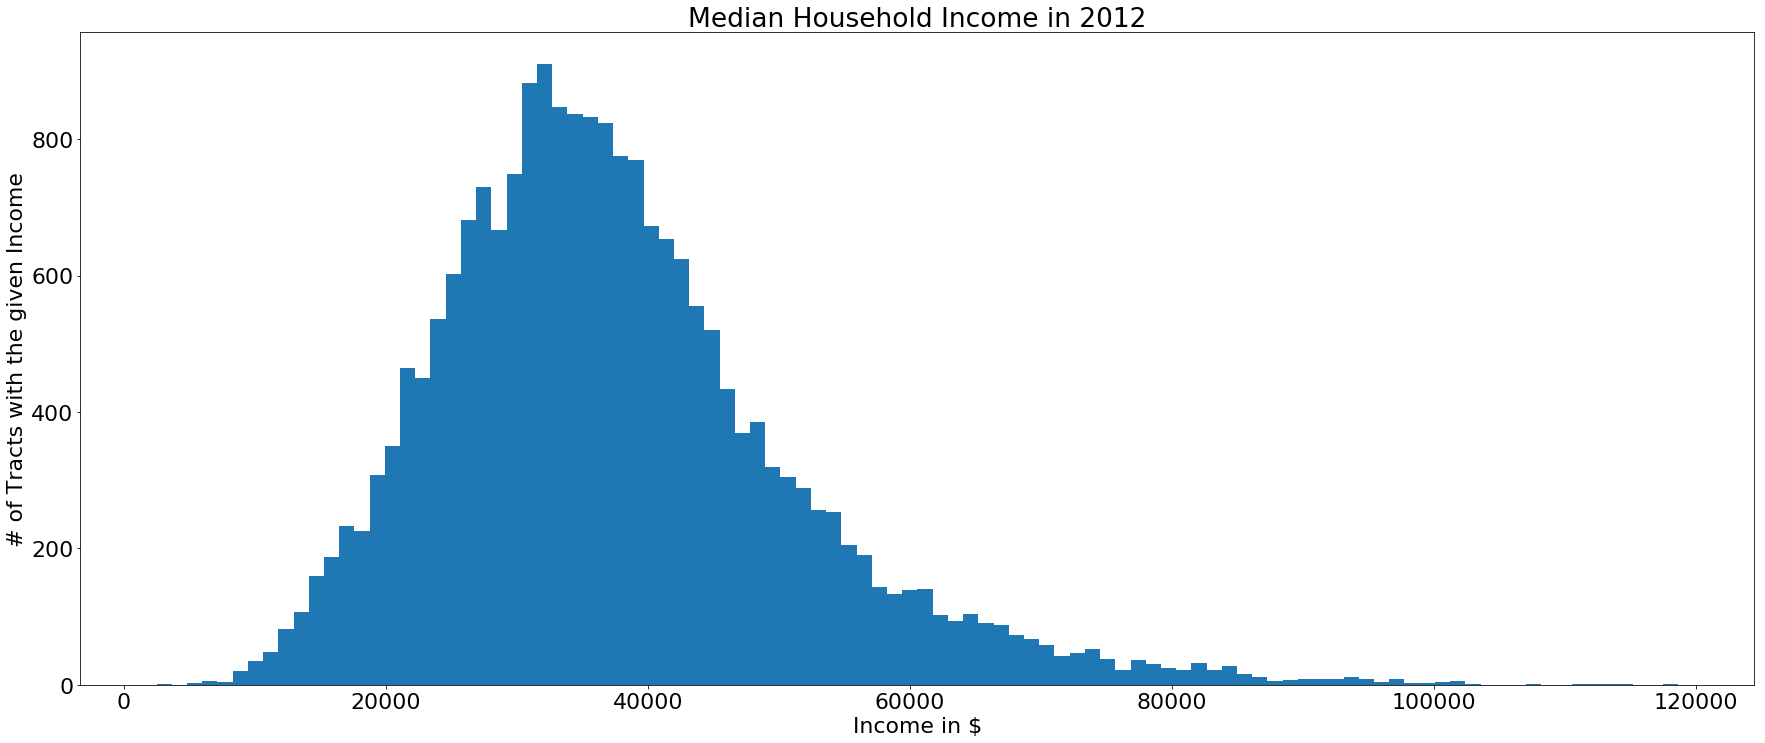

In [44]:
values = master['income_2012']
plt.figure(figsize=(30, 12))
plt.hist(values, bins=100)
plt.title('Median Household Income in 2012')
plt.ylabel('# of Tracts with the given Income')
plt.xlabel('Income in $')

In [45]:
master['income_2012'].mean()

37430.67914869413

Text(0.5, 0, 'Income in $')

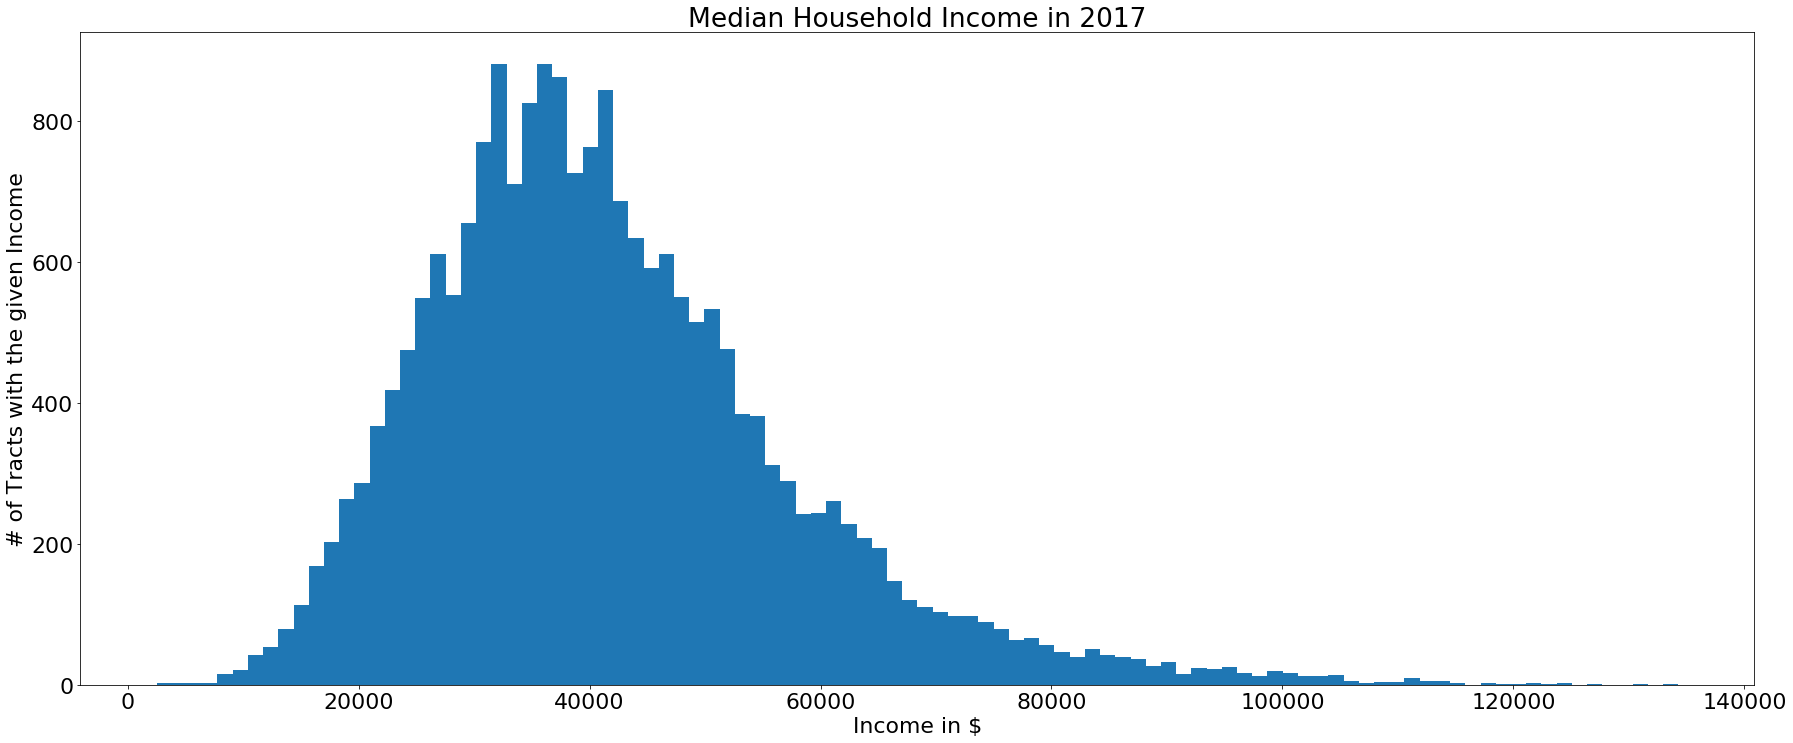

In [46]:
values = master['income_2017']
plt.figure(figsize=(30, 12))
plt.hist(values, bins=100)
plt.title('Median Household Income in 2017')
plt.ylabel('# of Tracts with the given Income')
plt.xlabel('Income in $')

In [47]:
master['income_2017'].mean()

41748.89396596672

Note the shift to the right in 2017 Income, this represents the increase in the mean income from 2012 to 2017 from \\$37,430 to \\$41,748.

Text(0.5, 0, 'Home Value in $')

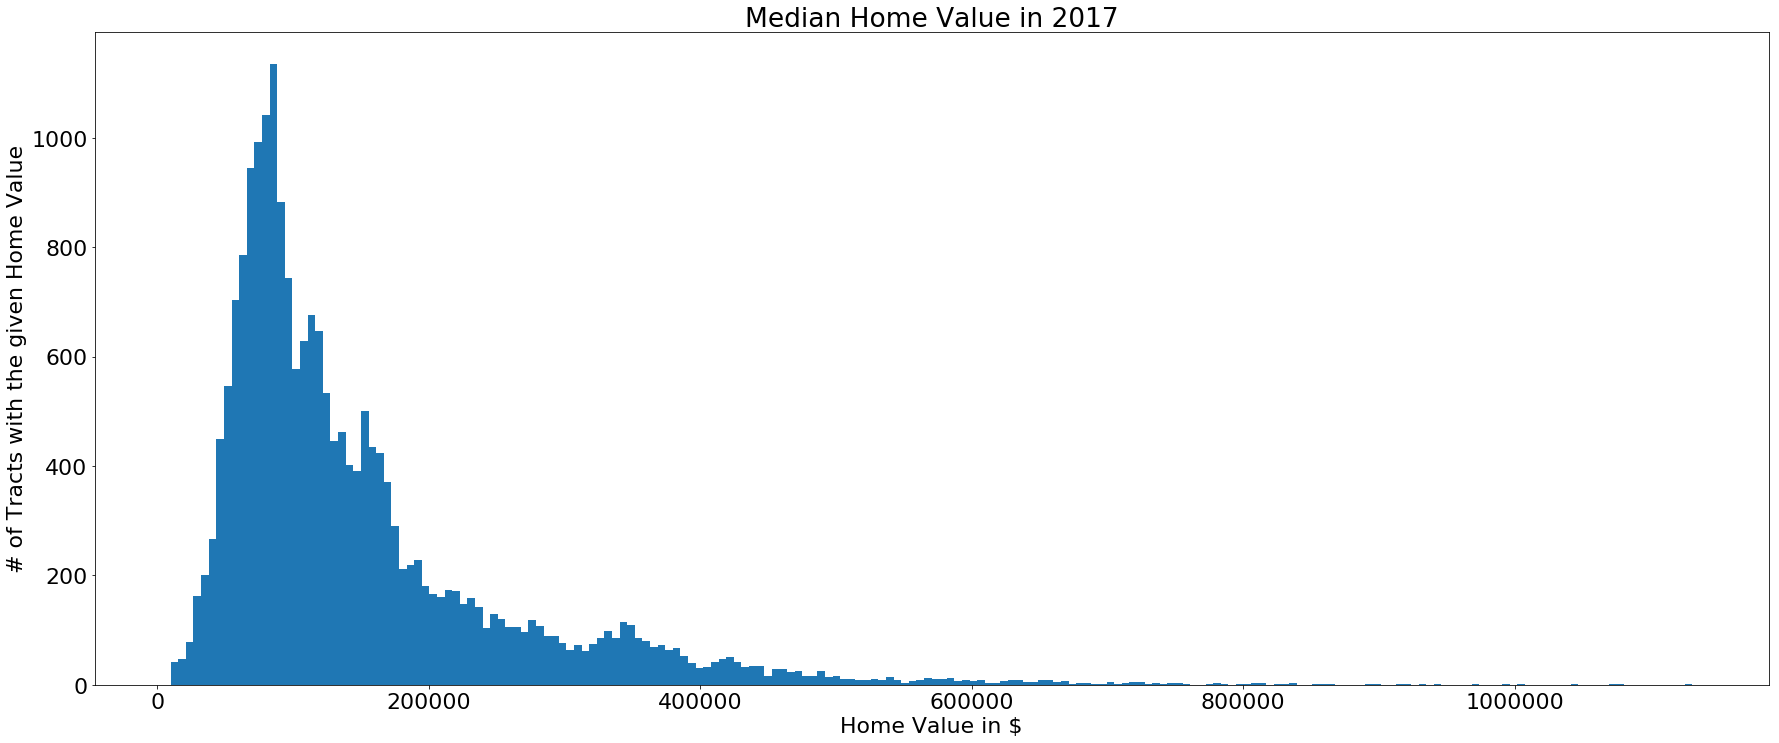

In [48]:
values = master['home_2017']
plt.figure(figsize=(30, 12))
plt.hist(values, bins=200)
plt.title('Median Home Value in 2017')
plt.ylabel('# of Tracts with the given Home Value')
plt.xlabel('Home Value in $')

### Feature Extraction

In [17]:
master['RenterOccupied'] = (master['HousesRented_2017']/master['TotalHousesTenure_2017']) - (master['HousesRented_2012']/master['TotalHousesTenure_2012'])
master['HousesVacant'] = (master['HousesVacant_2017']/master['TotalHousesOcc_2017']) - (master['HousesVacant_2012']/master['TotalHousesOcc_2012'])
master['AfAm'] = (master['AfAm_2017'] / master['TotalPopDem_2017']) - (master['AfAm_2012'] / master['TotalPopDem_2012'])
master['Asian'] = (master['AsianDem_2017'] / master['TotalPopDem_2017']) - (master['AsianDem_2012'] / master['TotalPopDem_2012'])
master['TravelTime'] = (master['TravelTime_2017'] - master['TravelTime_2012']) / master['TravelTime_2012']
master['VehiclesUsed'] = (master['VehiclesUsed_2017'] - master['VehiclesUsed_2012']) / master['VehiclesUsed_2012']

master['Masters'] = (master['Masters_Degrees_2017'] - master['Masters_Degrees_2012']) / master['Masters_Degrees_2012']
master['Professionals'] = (master['Professional_Degrees_2017'] - master['Professional_Degrees_2012']) / master['Professional_Degrees_2012']

master['White_Home'] = (master['White_Houses_2017']-master['White_Houses_2012'])/master['White_Houses_2012']
master['AA_Home'] = (master['African_American_2017']-master['African_American_2012'])/master['African_American_2012']
master['Asian_Home'] = (master['Asian_2017']-master['Asian_2012'])/master['Asian_2012']
master['Vacant_Homes'] = (master['Vacant_Homes_2017']-master['Vacant_Homes_2012'])/master['Vacant_Homes_2012']
master['Avg_House_Size'] = (master['Avg_House_Size_2017']-master['Avg_House_Size_2012'])/master['Avg_House_Size_2012']
master['Median_Num_Rooms'] = (master['Median_Num_Rooms_2017']-master['Median_Num_Rooms_2012'])/master['Median_Num_Rooms_2012']

In [18]:
master['popAccel'] = (((master['population_2015'] - master['population_2014']) - (master['population_2014'] - master['population_2013'])) + ((master['population_2014'] - master['population_2013'])-(master['population_2013'] - master['population_2012'])))/2
master['incAccel'] = (((master['income_2015'] - master['income_2014']) - (master['income_2014'] - master['income_2013'])) + ((master['income_2014'] - master['income_2013'])-(master['income_2013'] - master['income_2012'])))/2
master['bachAccel'] = (((master['bachelors_2015'] - master['bachelors_2014']) - (master['bachelors_2014'] - master['bachelors_2013'])) + ((master['bachelors_2014'] - master['bachelors_2013'])-(master['bachelors_2013'] - master['bachelors_2012'])))/2
master['homeVelAccel'] = (((master['home_2015'] - master['home_2014']) - (master['home_2014'] - master['home_2013'])) + ((master['home_2014'] - master['home_2013'])-(master['home_2013'] - master['home_2012'])))/2

master['popVelAvg'] = ((master['population_2015'] - master['population_2014']) + (master['population_2014'] - master['population_2013']) + (master['population_2013'] - master['population_2012']))/3
master['incVelAvg'] = ((master['income_2015'] - master['income_2014']) + (master['income_2014'] - master['population_2013']) + (master['income_2013'] - master['income_2012']))/3
master['bachVelAvg'] = ((master['bachelors_2015'] - master['bachelors_2014']) + (master['bachelors_2014'] - master['bachelors_2013']) + (master['bachelors_2013'] - master['bachelors_2012']))/3
master['homeVelAvg'] = ((master['home_2015'] - master['home_2014']) + (master['home_2014'] - master['home_2013']) + (master['home_2013'] - master['home_2012']))/3

In [21]:
master["Masters"].fillna(100, inplace=True)
master["Professionals"].fillna(100, inplace=True)
master.replace(np.inf, 0, inplace=True)

In [24]:
masterClean = master[['NAME','state', 'county', 'tract', 'GENTRIFIED', 'RenterOccupied', 'HousesVacant', 'AfAm', 'Asian', 'TravelTime', 'VehiclesUsed', 'Masters','Professionals','White_Home','AA_Home','Asian_Home','Vacant_Homes','Avg_House_Size','Median_Num_Rooms', 'popAccel', 'incAccel', 'bachAccel', 'homeVelAccel', 'popVelAvg', 'incVelAvg', 'bachVelAvg', 'homeVelAvg']]
print("ORIGINAL SIZE: ", masterClean.shape[0])
masterClean = masterClean.dropna()
print("NEW SIZE: ", masterClean.shape[0])
masterReduced = masterClean

ORIGINAL SIZE:  21097
NEW SIZE:  14137


In [36]:
masterReduced.head()

,NAME,state,county,tract,GENTRIFIED,RenterOccupied,HousesVacant,AfAm,Asian,TravelTime,...,Avg_House_Size,Median_Num_Rooms,popAccel,incAccel,bachAccel,homeVelAccel,popVelAvg,incVelAvg,bachVelAvg,homeVelAvg
0,"Census Tract 8808, Cape Girardeau County, Miss...",29,31,880800,1,0.096519,-0.032565,0.063041,-0.013667,0.118418,...,-0.046875,-0.200000,48.0,3953.0,3.5,5350.0,72.666667,3890.666667,21.000000,3733.333333
1,"Census Tract 8809, Cape Girardeau County, Miss...",29,31,880900,0,0.092664,0.058573,0.025674,0.074964,0.107348,...,0.234234,0.090909,-58.0,-1764.5,-18.5,600.0,12.666667,13200.666667,4.666667,-2400.000000
2,"Census Tract 8814, Cape Girardeau County, Miss...",29,31,881400,0,-0.194425,0.103416,0.020955,-0.001321,0.042335,...,-0.210526,0.020833,-64.0,-256.5,9.5,4150.0,-178.666667,4038.000000,-5.000000,3533.333333
3,"Census Tract 8816, Cape Girardeau County, Miss...",29,31,881600,0,0.045210,0.102539,0.104162,0.024428,0.109698,...,0.064516,0.000000,-116.0,613.5,28.5,-1050.0,126.333333,9030.000000,1.000000,-1333.333333
4,"Census Tract 9603, Carroll County, Missouri",29,33,960300,1,0.028204,-0.000410,-0.016722,-0.003016,-0.289163,...,0.000000,0.036364,91.5,317.0,-4.5,-6850.0,29.333333,9940.000000,-18.333333,-1066.666667


## Test Valid Train Split

In [25]:
X = masterReduced.drop(columns = ['NAME', 'state', 'county', 'tract', 'GENTRIFIED'])
y = masterReduced['GENTRIFIED']
np.random.seed(10)
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80,test_size = .20)

# Train/Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,train_size = .75, test_size = .25)

## Model - Logistic Regression

### Why logistic regression?
We did a logistic regression on our data, because this analysis aimed to perform classification. We aimed to use numerical census values (e.g. change in educational attainment) in order to delineate between a binary result (1 for gentrified, 0 for non gentrified).

### Refresher: What is logistic regression?
Logistic regression estimates the parameters of a logistic model. Using a target indicator variable (labeled 0 or 1), and input independent variables (our predictor variables), we predicted the probability of a certain input falling into either of the indicator variable buckets. Logistic regression is named as such because we used log as our sigmoid function (converts any input number to a value between 0 and 1). So given some regression of our inputs, we found the best weights for each input variable, that lead to the best probability estimates, that reduced our cost function (usually L2 Norm).

A more detailed, general explanation of logistic regression can be found [here](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc). A great in depth, mathematical explanation can be found on [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

In [27]:
logreg = linear_model.LogisticRegression(solver = "newton-cg")
#logreg = RFE(logreg, 22, step=1)  # <- Optional, can play around with if more features are added
log_model = logreg.fit(X_train, y_train)
log_pred = log_model.predict(X_validate)

## Results

In [28]:
np.mean(log_pred == y_validate)

0.7634370579915134

In [30]:
log_model.coef_

array([[-1.03466222e-01, -4.71841504e-03, -3.39015133e-02,
         2.57950787e-02,  1.02692325e-01,  1.86273441e-01,
        -3.21921501e-03, -1.56188089e-03, -6.29499007e-02,
        -1.56161266e-02, -4.52802819e-03,  1.91199068e-02,
        -1.18371333e-01,  4.01424340e-02, -9.79177245e-06,
        -1.54663597e-06, -4.59636931e-04, -2.63690759e-09,
        -1.93994533e-03, -1.14536469e-05,  2.96763875e-02,
         9.16605421e-05]])

In [35]:
results = perf_measure(np.array(y_validate), np.array(log_pred))
print("True Positive: ", results[0])
print("False Positive: ", results[1])
print("True Negative: ", results[2])
print("False Negative: ", results[3])

True Positive:  310
False Positive:  154
True Negative:  1849
False Negative:  515


# Conclusions

## Numerical Results
Our model had an accuracy of around 76% in predicting gentrification through our variables. This is only a 6% improvement from if we had guessed all areas as non-gentrified. 

We also had a precision of 67%, and a recall of of 38%. It turns out our model labels quite a few tracts as non-gentrified when they should be counted as gentrified. 


## Interpretation of results
- **Accuracy:** As we continued to add more features that we thought may be good proxies for factors outlined in Governing, we started being able to predict gentrification more accurately. 
- **Coefficients:** Our log model coefficients sign (positive vs negative) can be interpreted as being positively correlated or negatively correlated with gentrification. For example, increased vehicle usage as well as travel time to work were positively associated with gentrification whereas housing vacancy rates and rental occupancy percentages were negatively associated. The magnitude is a bit harder to visually understand because we're on a logarithmic scale, and these numbers should be converted into odds ratios to really be interpretable.
- **Poor Precision**: We have very low precision because there are a large number of tracts being categorized incorrectly as non-gentrified. This can likely be fixed if we include a lot more features (we currently have only around 20), and do some feature selection later to narrow down.

## Possible gaps and how to fix them
A clearly defined threshold or methodology around using velocities (year over year change) needs to be explored as well. This could be accomplished by looking at past areas that have become gentrified and seeing how their velocities affected their transition. Then it would be helpful to have a pilot study on cities today that fit the proposed profile and track their progress over the next few years to see if/how they gentrify. 

Given the sensitivity of this question we also would like to reduce false negatives by introducing more features to improve the model given the consequences of not being categorized properly. 

As mentioned earlier, the geographic restrictions from the ACS proved difficult at times but are clearly needed to preserve privacy and individual rights.

## Reflecting on methods used
Our methods and exploration were mostly successful in our goal to find features that can better define gentrification in a shorter time span. The major challenge was working around the geographic level restrictions in place from the ACS. Those restrictions are in place for a good reason and prevent data being used to personally identify an individual. Any future investigation and data collection would have to be careful the data is used in a responsible way that benefits communities.

## Implications
Understanding areas where gentrification is starting to occur faster than is currently possible clearly has positive benefits for defending existing communities, however there are many negatives that need to be mitigated. If companies or real estate developers use the tool to plan store placement and high-rise development in up and coming areas, the tool will have aided in the very thing it is trying to prevent. So possibly restricting how widely this tool is deployed or who has access to it would be a prudent move in the future. 
